In [2]:
import sys
sys.path.append("../../../../src")
sys.path.append('../../../../../mpisppy')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand_lb
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from pyomo.environ import value as pyo_val
from energiapy.utils.scale_utils import scale_pyomo_set, scale_tuple, scale_list, scale_changer
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List
from pyomo.environ import ConcreteModel, Var, Constraint, NonNegativeReals
from pyomo.contrib.iis import write_iis
import time
from mpisppy.utils import sputils 
from mpisppy.opt.ef import ExtensiveForm
import networkx as nx

In [3]:
schedule_time_intervals = 7  # Number of time intervals in a planning horizon
_coms = 1
design_exec_scenarios = 4  # Number of execution scenarios
schedule_exec_scenarios = 52

M = 1e3  # Big M
# Define temporal scales
# scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])
design_annualization_factor = 1/design_exec_scenarios
schedule_annualization_factor = 1/schedule_exec_scenarios

In [4]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [5]:
def sum_probabilities(d:dict):
    total_prob = 0

    def recursive_sum(current_dict:dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [6]:
def create_design_scenario_dict(n_total: int):
    scenario_dict = {
        'cap2_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_2': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.085, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},

        'cap4_1': {'prob': 0.025, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_2': {'prob': 0.075, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_3': {'prob': 0.09, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},

        'res6_1': {'prob': 0.015, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},
        'res6_2': {'prob': 0.08, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.085, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},

        'trans25_1': {'prob': 0.02, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): create_list(n_total, 1)})},
        'trans25_2': {'prob': 0.035, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): create_list(n_total, 2)})},
        'trans25_3': {'prob': 0.09, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): create_list(n_total, 3)})},
        
        'trans47_1': {'prob': 0.04, 'factor': pandas.DataFrame(data={('trans47', 'com1_loc4_out'): create_list(n_total, 1)})},
        'trans47_2': {'prob': 0.085, 'factor': pandas.DataFrame(data={('trans47', 'com1_loc4_out'): create_list(n_total, 2)})},
        'trans47_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('trans47', 'com1_loc4_out'): create_list(n_total, 3)})},
        
        'no_disruption': {'prob': 0.11, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): [1] * n_total})}
    }
    
    norm_factor = sum(scenario_dict[k]['prob'] for k in scenario_dict)
    
    for k in scenario_dict: scenario_dict[k]['prob'] /= norm_factor

    return scenario_dict

In [7]:
def build_design_model(scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * design_exec_scenarios)
    scale_factor = 13*7
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[1, design_exec_scenarios])
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*scale_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/scale_factor, vopex=5, store_min=0.01, store_max= 100*scale_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * scale_factor
    truck_cap13 = 30 * scale_factor
    truck_cap24 = 50 * scale_factor
    truck_cap25 = 30 * scale_factor
    truck_cap34 = 30 * scale_factor
    truck_cap45 = 100 * scale_factor
    truck_cap47 = 40 * scale_factor
    truck_cap64 = 50 * scale_factor
    truck_cap75 = 40 * scale_factor
    
    plane_cap15 = 50 * scale_factor
    plane_cap65 = 50 * scale_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin)
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin)
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [plane65], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, 150, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('trans12', 'com1_loc1_out')]] if ('trans12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('trans13', 'com1_loc1_out')]] if ('trans13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('trans24', 'com1_loc2_out')]] if ('trans24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('trans25', 'com1_loc2_out')]] if ('trans25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('trans34', 'com1_loc3_out')]] if ('trans34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('trans45', 'com1_loc4_out')]] if ('trans45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('trans47', 'com1_loc4_out')]] if ('trans47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('trans64', 'com1_loc6_out')]] if ('trans64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('trans75', 'com1_loc7_out')]] if ('trans75', 'com1_loc7_out') in scen_df else default_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*scale_factor
    demand_penalty = 500
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'design scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Design Scenario', annualization_factor=1)
    
    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
        
        problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
        
        def first_stage_cost_rule(instance):
            return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
        
        problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
        
        return scenario, problem_mincost
    else:
        return scenario

In [8]:
def build_design_smodel(scen_df=pandas.DataFrame()):
    scenario = build_design_model(scen_df)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

    problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')

    def first_stage_cost_rule(instance):
        return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) +
                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))

    problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

    return scenario, problem_mincost

In [9]:
def design_scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    scen, model = build_design_smodel(scen_df=scen_dict[scen_name]['factor'])
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [10]:
solver_options = {
    'MIPGap': 0.005,
    'Heuristics': 0.20
}

In [11]:
design_scenario_dict = create_design_scenario_dict(n_total=design_exec_scenarios)
design_scenario_names = list(design_scenario_dict.keys())

In [12]:
print(f"Sum of probabilities of all scenarios: {sum(design_scenario_dict[scen]['prob'] for scen in design_scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(design_scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 16


In [13]:
start = time.time()
options = {"solver": "gurobi"}
design_scenario_creator_kwargs = {'scenario_dict': design_scenario_dict}
ef_UI = ExtensiveForm(options, design_scenario_names, design_scenario_creator,
                      scenario_creator_kwargs=design_scenario_creator_kwargs)
results = ef_UI.solve_extensive_form(solver_options=solver_options)
end = time.time()

[   33.67] Initializing SPBase


In [14]:
print(f'Execution Time: {end - start:.4f}')

Execution Time: 5.9918


In [15]:
exCost_UI = ef_UI.get_objective_value()
ssoln_UI = ef_UI.get_root_solution()
first_stage_cost = getattr(ef_UI.ef, design_scenario_names[0]).first_stage_cost.value

print(f"Expected Cost under Uncertain Information: {exCost_UI:.4f}")
print(f"First Stage Cost: {first_stage_cost:.4f}")

Expected Cost under Uncertain Information: 601485.5470
First Stage Cost: 31241.6000


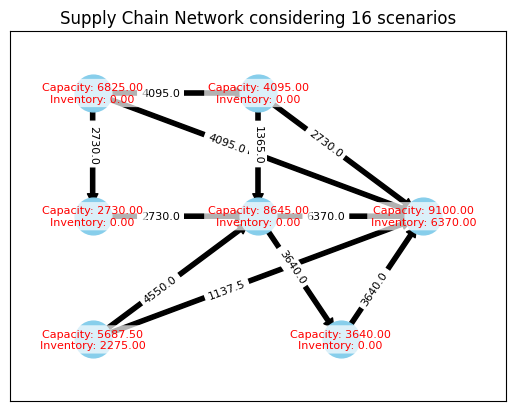

In [16]:
G = nx.DiGraph()

# with open(fr"ssoln_4096_UI_HP.pkl", 'rb') as file:
#     ssoln_dict = pickle.load(file)

ssoln_dict = ssoln_UI
nodes = {
'Location 1': {
    'Capacity': ssoln_dict['Cap_P[loc1,com1_process,0]'] if 'Cap_P[loc1,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc1,com1_store_com1_in_stored,0]'] if 'Cap_S[loc1,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 2': {
    'Capacity': ssoln_dict['Cap_P[loc2,com1_process,0]'] if 'Cap_P[loc2,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc2,com1_store_com1_in_stored,0]'] if 'Cap_S[loc2,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 3': {
    'Capacity': ssoln_dict['Cap_P[loc3,com1_process,0]'] if 'Cap_P[loc3,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc3,com1_store_com1_in_stored,0]'] if 'Cap_S[loc3,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 4': {
    'Capacity': ssoln_dict['Cap_P[loc4,com1_process,0]'] if 'Cap_P[loc4,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc4,com1_store_com1_in_stored,0]'] if 'Cap_S[loc4,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 5': {
    'Capacity': ssoln_dict['Cap_P[loc5,com1_process,0]'] if 'Cap_P[loc5,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc5,com1_store_com1_in_stored,0]'] if 'Cap_S[loc5,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 6': {
    'Capacity': ssoln_dict['Cap_P[loc6,com1_process,0]'] if 'Cap_P[loc6,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc6,com1_store_com1_in_stored,0]'] if 'Cap_S[loc6,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 7': {
    'Capacity': ssoln_dict['Cap_P[loc7,com1_process,0]'] if 'Cap_P[loc7,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc7,com1_store_com1_in_stored,0]'] if 'Cap_S[loc7,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges (connections between nodes)
edges = [
    ('Location 1', 'Location 2', {'weight': ssoln_dict['Cap_F[loc1,loc2,truck12,0]'] if 'Cap_F[loc1,loc2,truck12,0]' in ssoln_dict.keys() else 0}),
    ('Location 1', 'Location 3', {'weight': ssoln_dict['Cap_F[loc1,loc3,truck13,0]'] if 'Cap_F[loc1,loc3,truck13,0]' in ssoln_dict.keys() else 0}),
    ('Location 1', 'Location 5', {'weight': ssoln_dict['Cap_F[loc1,loc5,plane15,0]'] if 'Cap_F[loc1,loc5,plane15,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 4', {'weight': ssoln_dict['Cap_F[loc2,loc4,truck24,0]'] if 'Cap_F[loc2,loc4,truck24,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 5', {'weight': ssoln_dict['Cap_F[loc2,loc5,truck25,0]'] if 'Cap_F[loc2,loc5,truck25,0]' in ssoln_dict.keys() else 0}),
    ('Location 3', 'Location 4', {'weight': ssoln_dict['Cap_F[loc3,loc4,truck34,0]'] if 'Cap_F[loc3,loc4,truck34,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 5', {'weight': ssoln_dict['Cap_F[loc4,loc5,truck45,0]'] if 'Cap_F[loc4,loc5,truck45,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 7', {'weight': ssoln_dict['Cap_F[loc4,loc7,truck47,0]'] if 'Cap_F[loc4,loc7,truck47,0]' in ssoln_dict.keys() else 0}),
    ('Location 6', 'Location 4', {'weight': ssoln_dict['Cap_F[loc6,loc4,truck64,0]'] if 'Cap_F[loc6,loc4,truck64,0]' in ssoln_dict.keys() else 0}),
    ('Location 6', 'Location 5', {'weight': ssoln_dict['Cap_F[loc6,loc5,plane65,0]'] if 'Cap_F[loc6,loc5,plane65,0]' in ssoln_dict.keys() else 0}),
    ('Location 7', 'Location 5', {'weight': ssoln_dict['Cap_F[loc7,loc5,truck75,0]'] if 'Cap_F[loc7,loc5,truck75,0]' in ssoln_dict.keys() else 0}),
]

# Add edges to the graph
G.add_edges_from(edges)

# Define fixed positions for nodes
fixed_positions = {
    'Location 1': (-2, 2),
    'Location 2': (0, 2),
    'Location 3': (-2, 0),
    'Location 4': (0, 0),
    'Location 5': (2, 0),
    'Location 6': (-2, -2),
    'Location 7': (1, -2)
}

# Create custom labels combining multiple pieces of information
node_labels = {node: f"Capacity: {data['Capacity']:.2f}\nInventory: {data['Inventory']:.2f}" for node, data in nodes.items()}

# Draw nodes and edges with fixed positions
nx.draw_networkx_nodes(G, fixed_positions, node_color='skyblue', node_size=700)
nx.draw_networkx_edges(G, fixed_positions, edgelist=edges, arrowstyle='simple', arrowsize=15)
nx.draw_networkx_labels(G, fixed_positions, labels=node_labels, font_size=8, font_color='red', bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3"))

# Draw edge labels (optional)
edge_labels = {(u, v): round(d['weight'],3) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, fixed_positions, edge_labels=edge_labels, label_pos=0.4, font_size=8)

# Expand plot limits to prevent cutoff
x_values, y_values = zip(*fixed_positions.values())
plt.xlim(min(x_values) - 1, max(x_values) + 1)
plt.ylim(min(y_values) - 1, max(y_values) + 1)

# Show the plot
plt.title(f"Supply Chain Network considering {len(design_scenario_names)} scenarios")
# plt.figure(figsize=(16,12))
plt.show()  

# Design Complete

In [ ]:
def build_schedule_model(start_time:tuple, end_time:tuple, scen_df=pandas.DataFrame(), eps:float=1.0):
    default_df = pandas.DataFrame(data=[1] * schedule_exec_scenarios)
    scale_factor = 1
    fudge_factor = 5
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[1, schedule_exec_scenarios, schedule_time_intervals], start_zero=start_time, end_zero=end_time)
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*scale_factor*fudge_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/scale_factor, vopex=5, store_min=0.01, store_max= 100*scale_factor*fudge_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * scale_factor * fudge_factor
    truck_cap13 = 30 * scale_factor * fudge_factor
    truck_cap24 = 50 * scale_factor * fudge_factor
    truck_cap25 = 30 * scale_factor * fudge_factor
    truck_cap34 = 30 * scale_factor * fudge_factor
    truck_cap45 = 100 * scale_factor * fudge_factor
    truck_cap47 = 40 * scale_factor * fudge_factor
    truck_cap64 = 50 * scale_factor * fudge_factor
    truck_cap75 = 40 * scale_factor * fudge_factor
    
    plane_cap15 = 50 * scale_factor * fudge_factor
    plane_cap65 = 50 * scale_factor * fudge_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, M, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('trans12', 'com1_loc1_out')]] if ('trans12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('trans13', 'com1_loc1_out')]] if ('trans13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if (
                                                                                                                    'plane15',
                                                                                                                    'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('trans24', 'com1_loc2_out')]] if ('trans24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('trans25', 'com1_loc2_out')]] if ('trans25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('trans34', 'com1_loc3_out')]] if ('trans34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('trans45', 'com1_loc4_out')]] if ('trans45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('trans47', 'com1_loc4_out')]] if ('trans47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('trans64', 'com1_loc6_out')]] if ('trans64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('trans75', 'com1_loc7_out')]] if ('trans75', 'com1_loc7_out') in scen_df else default_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*scale_factor
    demand_penalty = 200
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'schedule scenario', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Schedule Scenario', annualization_factor=1)
    
    # ======================================================================================================================
    # Declare model
    # ======================================================================================================================
    
    problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.NETWORK}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
    
    demand = scenario.demand
    if isinstance(demand, dict):
        if isinstance(list(demand.keys())[0], Location):
            try:
                demand = {i.name: {
                    j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
            except:
                pass

    constraint_demand_lb(instance=problem_mincost, demand=demand, demand_factor=scenario.demand_factor,
                         demand_scale_level=scenario.demand_scale_level,
                         scheduling_scale_level=scenario.scheduling_scale_level,
                         location_resource_dict=scenario.location_resource_dict, epsilon=eps)
    
    return scenario, problem_mincost
    
    # if scen_df.empty:
    #     # ======================================================================================================================
    #     # Declare problem
    #     # ======================================================================================================================
    # 
    #     problem_mincost = formulate(scenario=scenario,
    #                                 constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
    #                                              Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
    #                                              Constraints.NETWORK},
    #                                 demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
    # 
    #     scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    #     # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    #     # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
    #     
    #     problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
    #     
    #     def first_stage_cost_rule(instance):
    #         return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
    #                                             sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
    #     
    #     problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
    #     
    #     return scenario, problem_mincost
    # else:
    #     return scenario

In [ ]:
def fix_design_variables(model2fix: ConcreteModel, design_model: ConcreteModel):
    if isinstance(design_model, ConcreteModel):
        model = getattr(design_model.ef, [i[0] for i in design_model.scenarios()][0])

        def fix(var1, var2):
            for i in list(var1.keys()):
                if var1[i].value is None:
                    continue
                elif ('X_P' in var1.name) or ('X_S' in var1.name) or ('X_F' in var1.name):
                    var2[i].fix(var1[i].value)
                elif ('Cap_P' in var1.name) or ('Cap_S' in var1.name) or ('Cap_F' in var1.name):
                    var2[i].fix(var1[i].value/91)
    
        fix(model.X_P, model2fix.X_P)
        fix(model.Cap_P, model2fix.Cap_P)
        fix(model.X_S, model2fix.X_S)
        fix(model.Cap_S, model2fix.Cap_S)
        fix(model.X_F, model2fix.X_F)
        fix(model.Cap_F, model2fix.Cap_F)
    
    elif isinstance(design_model, dict):
        # design_scen = list(design_model.keys())[0]
        
        def fix_dict(var, dict):
            for i in list(var.keys()):
                if dict[var.name][i] is None:
                    continue
                elif ('X_P' in var.name) or ('X_S' in var.name) or ('X_F' in var.name):
                    var[i].fix(dict[var.name][i])
                elif ('Cap_P' in var.name) or ('Cap_S' in var.name) or ('Cap_F' in var.name):
                    var[i].fix(dict[var.name][i])
        
        fix_dict(model2fix.X_P, design_model)
        fix_dict(model2fix.Cap_P, design_model)
        fix_dict(model2fix.X_S, design_model)
        fix_dict(model2fix.Cap_S, design_model)
        fix_dict(model2fix.X_F, design_model)
        fix_dict(model2fix.Cap_F, design_model)

In [ ]:
def fix_variables(model2fix: ConcreteModel, current_time_idx:tuple, initial_dict: dict,time_scales:TemporalScale):
    states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'Capex_process', 'Capex_storage', 'Inv_cost', 'X_F', 'Cap_F', 'Exp', 'Capex_transport', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']
    
    model2fix_vars = {v.name: v for v in model2fix.component_objects(Var) if v.name in states}
    
    for name, var in model2fix_vars.items():
        var_key_list = [k for k in var.keys()]
        updated_key_list = list()
        
        if var_key_list and var_key_list!= [None]:
            if isinstance(var_key_list[0], int):
                # updated_key_list = [i for i in var_key_list if tuple((i,)) < current_time_idx[:network_scale_level+1]] 
                continue
            elif isinstance(var_key_list[0], tuple) and ('location' not in name and 'network' not in name):
                num_integers = sum(1 for elem in var_key_list[0] if isinstance(elem, int))
                scale_length = min(len(time_scales.scale), num_integers)                
                updated_key_list = [k for k in var.keys()
                                    if tuple(k[-scale_length:]) < current_time_idx[:scale_length] or (tuple(k[-scale_length:]) == current_time_idx[:scale_length] and current_time_idx[1:]!=(0,)*(len(current_time_idx)-1) and tuple(k[-scale_length:]) != current_time_idx)]
                
            for key in updated_key_list:
                if key in initial_dict[name] and initial_dict[name][key] is not None:
                    if not var[key].fixed:
                        var[key].fix(initial_dict[name][key])
                    # var[key].fixed = True
                    # var[key] = initial_dict[name][key]
    print(f"Variables fixed for time {current_time_idx}")

In [ ]:
def print_fixed_variables(instance:ConcreteModel):    
    for v in instance.component_objects(Var):
        for index in v:
            if v[index].fixed:
                print(f"{v.name}[{index}]: {v[index].value}")

def get_fixed_variables(instance:ConcreteModel):
    return {v.name: {index: v[index].value for index in v if v[index].fixed} for v in instance.component_objects(Var)}

In [ ]:
model_record = dict()
scenario_record = dict()
results_record = dict()

In [ ]:
scheduling_scales = TemporalScale(discretization_list=[1, schedule_exec_scenarios, schedule_time_intervals])
scale_iter_list = scheduling_scales.scale_iter(scale_level=len(scheduling_scales.scale)-1)

In [ ]:
def supply_chain_controller(time_ind:List, start_at:Union[int, Tuple]=0, end_at:Union[int, Tuple]=None, initialize_dict:dict=None, p_horizon:int=1, c_horizon:int=1, lookback:int=0, design_model:ConcreteModel=None, eps:float=1):
    
    end_at = end_at or len(time_ind)-1
    
    close_loop_results = dict()
    if c_horizon > p_horizon:
        raise ValueError('c_horizon must be less than or equal to p_horizon')
    
    if isinstance(start_at, Tuple):
        if start_at not in time_ind:
            raise ValueError('Incorrect start time value')
        start_idx = time_ind.index(start_at)
    else:
        start_idx = start_at
        
    if isinstance(end_at, Tuple):
        if end_at not in time_ind:
            raise ValueError('Incorrect end time value')
        end_idx = time_ind.index(end_at)
    else:
        end_idx = end_at
    
    if end_idx < start_idx:
        raise ValueError('Incorrect start and end time values')

    # print(f"Starting Index: {start_idx}; Starting Time: {start_time}")
    # print(f"Ending Index: {end_idx}; Ending Time: {end_time}")
    
    
    for t in range(start_idx, end_idx+1, c_horizon):
        start_time = max(0, t-lookback)
        end_time = min(t+p_horizon, end_idx)
        scenario, model = build_schedule_model(start_time=time_ind[start_time], end_time=time_ind[end_time], eps= eps)
        scenario_record[time_ind[t]] = scenario
        model_record[time_ind[t]] = model
        
        if t==start_idx and design_model:
            print(f"Time index: {t}")
            fix_design_variables(model2fix=model, design_model=design_model)

        if time_ind[t-1] in close_loop_results:
            fix_variables(model2fix=model, initial_dict=close_loop_results[time_ind[t-1]], current_time_idx=time_ind[t], time_scales=scenario.scales)
        
        result = solve(scenario=scenario, instance=model, solver='gurobi', name='MILP')
        model_vars = model.component_map(ctype=Var)
        close_loop_results[time_ind[t]] = {i: model_vars[i].extract_values() for i in model_vars.keys()}
        results_record[time_ind[t]] = result

        print(f'\n################################## Finished solving problem for time period {time_ind[t]} out of {time_ind[-1]} ##################################\n')
        # final_results = compile_results(close_loop_results=close_loop_results, time_dict = time_ind, start = start_idx, end = end_idx)
    
    return close_loop_results

In [ ]:
close_loop_results = supply_chain_controller(time_ind=scale_iter_list, c_horizon=1, p_horizon=5, end_at=(0,3,6), design_model=ef_UI)

In [ ]:
t = (0,0,0)

In [ ]:
d = get_fixed_variables(model_record[t])

In [ ]:
d

In [ ]:
print(*[(v, key, value) for v in d for key, value in d[v].items() if value], sep='\n')

In [ ]:
print(*[(key, value) for key, value in ssoln_dict.items() if value and 'Cap_P' in key], sep='\n')

In [ ]:
for time_key in model_record:
    print(f"Objective for {time_key}: {pyo_val(model_record[time_key].objective_cost_w_demand_penalty):.4f}")

In [ ]:
model_record[(0,0,0)].objective_cost_w_demand_penalty.pprint()

In [ ]:
pyo_val(model_record[(0,0,0)].objective_cost_w_demand_penalty)

In [ ]:
model_record[t].Demand_penalty_network.pprint()

In [ ]:
model_record[t].constraint_demand_penalty_network.pprint()

In [ ]:
model_record[(0,3,2)].constraint_demand_penalty_location.pprint()